# Klasyfikacja obiektów kosmicznych - Modelowanie
#### 0. Dane 
#### 0.1. Pakiety


In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# scaling
from sklearn.preprocessing import MinMaxScaler

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# svm
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# naive bayes gaussianNB
from sklearn.naive_bayes import GaussianNB

# knn
from sklearn.neighbors import KNeighborsClassifier

# adaboost
from sklearn.ensemble import AdaBoostClassifier

# svc
from sklearn.svm import SVC

# crossvalidation & hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


#### 0.2. Podział na zbiór treningowy i testowy

In [103]:
# wczytanie danych
df = pd.read_csv('./data/development_data.csv')

# podział danych na zbiór treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# reset indeksów
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# kolumny z waznymi cechami
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'spec_obj_ID', 'redshift']

# X - ramka danych ograniczona do interesujących nas cech
X = train_df[imp_cols]
y = train_df['class'].values

X_test = test_df[imp_cols]
y_test = test_df['class'].values

### 0.3. Normalizacja

In [104]:
scaling = MinMaxScaler()
X = scaling.fit_transform(X)
X_test = scaling.transform(X_test)

X = pd.DataFrame(X, columns=imp_cols)
X_test = pd.DataFrame(X_test, columns=imp_cols)

## 1. Feature importance 
 Feature importance raz jeszcze.
- Wykorzystamy, oprócz Random Forest Classifier, Gini i AUC.  
- Nowopowstałe zmienne będące funkcjami redshift miały tak duże znaczenie, które było zwiększane przede wszystkim przez zmienną redshift. W związku z czym, nie wnosiły one nowych informacji do modelu, jedynie stanowiły słabe powielenie cechy redshift.  
- Wszelkie próby stworzenia cech niemających uzasadnienia fizycznego, np. modyfikacje redshift, alfa oraz delta, nie ulepszały naszego modelu.
- Wszystkie cechy mają niezerową wariancję (var > 0.0001).

In [98]:
# copy X for testing purposes
X_ = X.copy()

# add new features
X_['u-g'] = X_['u'] - X_['g']
X_['g-r'] = X_['g'] - X_['r']
X_['r-i'] = X_['r'] - X_['i']
X_['i-z'] = X_['i'] - X_['z']
X_['u-r'] = X_['u'] - X_['r']
X_['ug_mr'] = np.log(X_['u'] / X_['g'])
X_['ri_mr'] = np.log(X_['r'] / X_['i'])
X_['iz_mr'] = np.log(X_['i'] / X_['z'])

# add new features to the list of important columns
imp_cols_ = imp_cols + ['u-g', 'g-r', 'r-i', 'i-z', 'u-r', 'ug_mr', 'ri_mr', 'iz_mr']

# change NaNs to median value --- there is only one NaN in each column
median_ug_mr = X_['ug_mr'].median()
X_['ug_mr'] = X_['ug_mr'].fillna(median_ug_mr)

median_r_i = X_['ri_mr'].median()
X_['ri_mr'] = X_['ri_mr'].fillna(median_r_i)

median_iz_mr = X_['iz_mr'].median()
X_['iz_mr'] = X_['iz_mr'].fillna(median_iz_mr)


In [88]:
# define function to generate featrue importance plot
def plot_feature_importance(model, X, imp_cols):

    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    # Print feature ranking and name the features
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. Feature {imp_cols[indices[f]]} ({feature_importances[indices[f]]})")  
    
    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(imp_cols)[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

### 1.1. Random Forest Classifier

Feature ranking:
1. Feature redshift (0.4495571735359382)
2. Feature ri_mr (0.13254258574318298)
3. Feature g-r (0.09701784848937481)
4. Feature iz_mr (0.06983282992470993)
5. Feature u-r (0.06720007558823553)
6. Feature i-z (0.04365867905747776)
7. Feature r-i (0.03311546431753257)
8. Feature u-g (0.022163698093565044)
9. Feature z (0.020094197527958504)
10. Feature i (0.017405204411224794)
11. Feature g (0.014195708668332562)
12. Feature spec_obj_ID (0.01055534564942468)
13. Feature r (0.009173593565830453)
14. Feature ug_mr (0.00828725982564021)
15. Feature u (0.004464725217635982)
16. Feature alpha (0.0004875481243563388)
17. Feature delta (0.00024806225957977023)


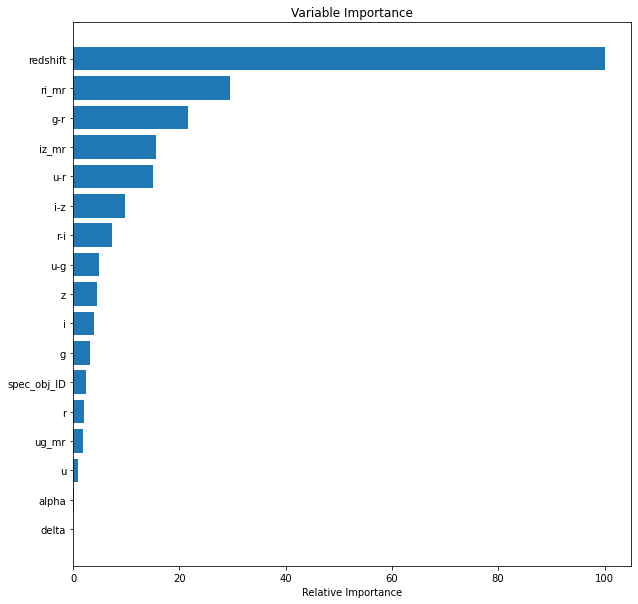

In [89]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

### 1.2. Gini

Feature ranking:
1. Feature redshift (0.8612806124630425)
2. Feature g-r (0.04893648780797637)
3. Feature r (0.015958441650050573)
4. Feature g (0.014996635345875975)
5. Feature spec_obj_ID (0.008162720433064236)
6. Feature ri_mr (0.005931104858314397)
7. Feature r-i (0.005594791796970766)
8. Feature delta (0.005273723088081056)
9. Feature alpha (0.0051520999143190695)
10. Feature u-r (0.005054991177883805)
11. Feature ug_mr (0.004087356543786321)
12. Feature i-z (0.004061979839340624)
13. Feature z (0.003359090744403863)
14. Feature iz_mr (0.0031881962821319475)
15. Feature u (0.0031816498822822325)
16. Feature i (0.0029445116251987737)
17. Feature u-g (0.002835606547277209)


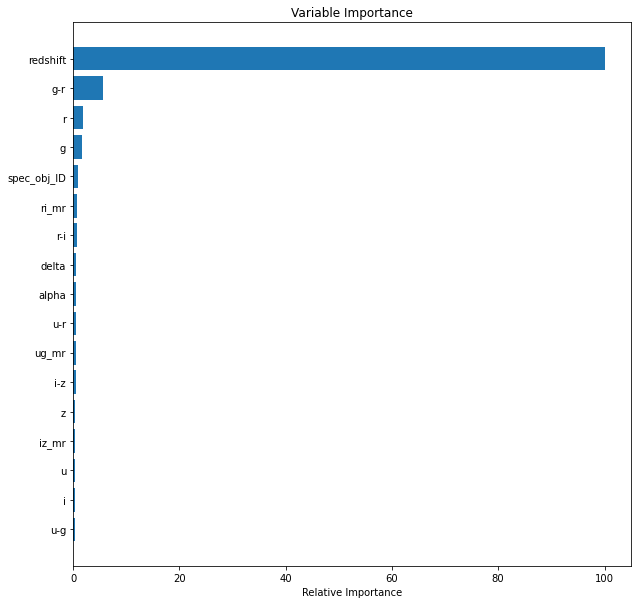

In [90]:
# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_, imp_cols_)

Według modelu Gini, cechami posiadającymi współczynnik ważności >= 5% są:
- redshift,
- g-r.  

A co jeśli nie będzie redshift?
### 1.2.1. Gini, ale bez zmiennej redshift CZY TO MA SENS???

Feature ranking:
1. Feature ri_mr (0.37314685307628903)
2. Feature u-r (0.12662976434195208)
3. Feature spec_obj_ID (0.09180271546275612)
4. Feature g-r (0.0697556382795857)
5. Feature iz_mr (0.041596782934339535)
6. Feature i (0.0411664753459561)
7. Feature r-i (0.0334788506378608)
8. Feature g (0.03318187558710901)
9. Feature u-g (0.03239837159215786)
10. Feature alpha (0.02713154341322022)
11. Feature delta (0.02624258901405764)
12. Feature z (0.025532076175611138)
13. Feature ug_mr (0.02349336769043515)
14. Feature i-z (0.023359640875128554)
15. Feature u (0.01811105085187495)
16. Feature r (0.012972404721666076)


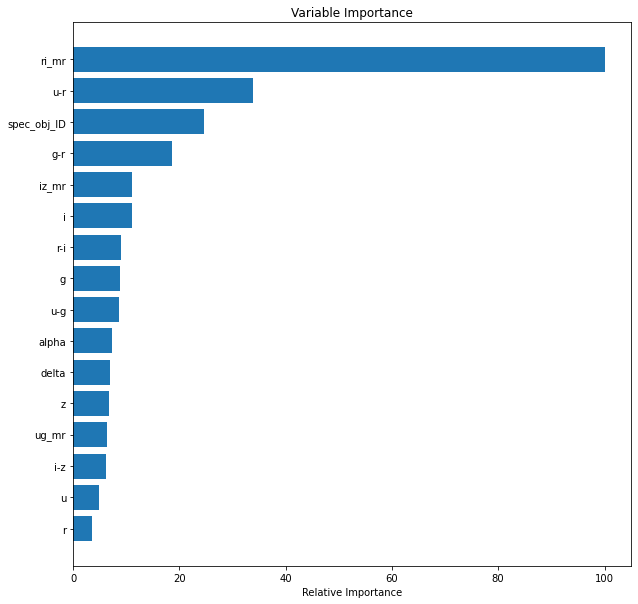

In [91]:
# for testing purposes remove redshift from X_
X_no_redshift = X_.drop(columns=['redshift'])
imp_cols_no_redshift = imp_cols_.copy()
imp_cols_no_redshift.remove('redshift')

# train gini
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_no_redshift, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X_no_redshift, imp_cols_no_redshift)

Teraz, zmienne:
- ri_mr (poprzednio bardzo nisko),
- u-r,
- spec_obj_ID,
- g-r

mają współczynniki Gini >= 5%.

### 1.3. Tylko cechy podstawowe


Random Forest
Feature ranking:
1. Feature redshift (0.6645266697666725)
2. Feature z (0.09700775427299273)
3. Feature g (0.06262542492272952)
4. Feature i (0.062055616537353635)
5. Feature u (0.05567218816556349)
6. Feature spec_obj_ID (0.03446543552736725)
7. Feature r (0.021729454403647395)
8. Feature delta (0.0011434600187883348)
9. Feature alpha (0.0007739963848850892)


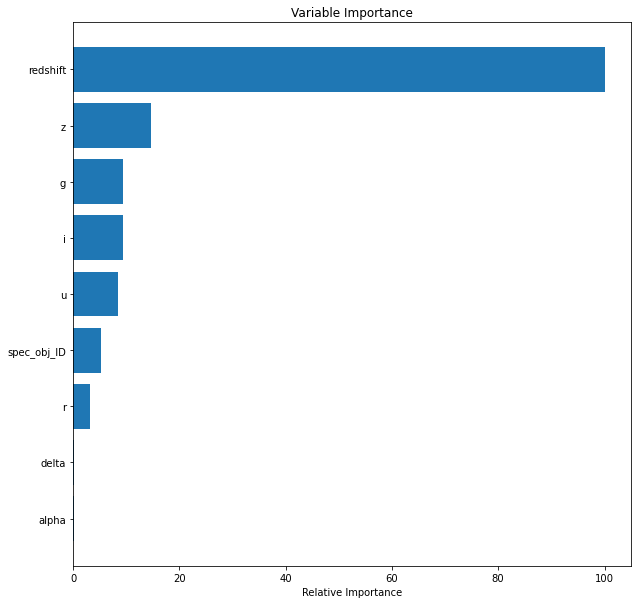

Gini Decision Tree
Feature ranking:
1. Feature redshift (0.8655909945368427)
2. Feature g (0.0537037419514874)
3. Feature u (0.02544293892291465)
4. Feature z (0.011691287518352961)
5. Feature i (0.010718054483345714)
6. Feature spec_obj_ID (0.009915345905802907)
7. Feature r (0.008653893749507268)
8. Feature alpha (0.007479638692331413)
9. Feature delta (0.006804104239414936)


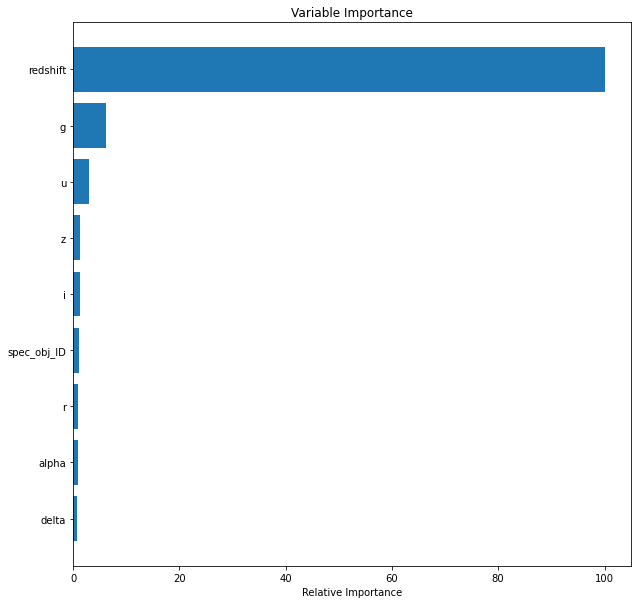

In [92]:
# train random forest classifier
print("Random Forest")
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

# train gini
print("Gini Decision Tree")
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X, y)

# get feature importances from the model
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plot_feature_importance(clf, X, imp_cols)

### 1.4. Wybór cech do modelu

Według **random forest classifier** najmniej istotnymi cechami były:
- u-g 
- z 
- i 
- g 
- spec_obj_ID 
- r 
- ug_mr 
- u 
- alpha 
- delta 

Według **gini (decision tree)** najmniej istotnymi cechami były:
- r
- r-i 
- alpha 
- ri_mr 
- delta 
- u-r 
- i-z 
- u-g 
- z 
- iz_mr 
- ug_mr 
- i 
- u 

Zatem w modelu nie będziemy uwzględniać:
- u
- alpha (choć mapa nieba inaczej sugerowała)
- delta (choć mapa nieba inaczej sugerowała)
- r (pomimo 3. pozycji w Gini (0.02 pkt))
- ug_mr
- u-g

Usuwamy powyższe z imp_cols_. Zachowamy ramki danych treningową i testową bez nowych cech pod zmiennymi X_org i X_test_org. Do ramek X i X_test dodajemy nowe cechy.

In [105]:
# let X_org be the original X and X_test_org be the original X_test
X_org = X.copy()
X_test_org = X_test.copy()

# let X be the X_ with removed columns
X = X_.drop(columns=['u', 'alpha', 'delta', 'r', 'ug_mr', 'u-g'])


# add 'g-r', 'r-i', 'i-z', 'u-r', 'ri_mr', 'iz_mr' to X_test 
X_test['g-r'] = X_test['g'] - X_test['r']
X_test['r-i'] = X_test['r'] - X_test['i']
X_test['i-z'] = X_test['i'] - X_test['z']
X_test['u-r'] = X_test['u'] - X_test['r']
X_test['ri_mr'] = np.log(X_test['r'] / X_test['i'])
X_test['iz_mr'] = np.log(X_test['i'] / X_test['z'])

# change NaNs to median value --- there is only one NaN in each column
median_r_i = X_test['ri_mr'].median()
X_test['ri_mr'] = X_test['ri_mr'].fillna(median_r_i)
median_iz_mr = X_test['iz_mr'].median()
X_test['iz_mr'] = X_test['iz_mr'].fillna(median_iz_mr)

X_test = X_test.drop(columns=['u', 'alpha', 'delta', 'r'])


Od teraz ramki danych są uzupełnione o stworzone i wybrane cechy.

## 3. Strojenie parametrów i przygotowanie cross-walidacji
Modele będziemy badać na wszystkim dostępnym zespołowi budowy danych - treningowych oraz na testowych. Ostatecznie wybierzemy najlepszy.  
Accuracy score będzie to uśredniony wynik dla dwóch zestawów danych (wagą będzie liczba rekordów w zestawie danych).  
Macierze wyświetlane są dla danych *testowych*, natomiast wyniki - dla obu.

W modelach badaliśmy różne parametry i wybraliśmy te o paramatrach z największą dokłądnością.

### 3.1. Strojenie parametrów
Wykorzystujemy RandomizedSearchCV do poszukiwania najlepszych parametrów dla naszych modeli.

In [165]:
def tune_hyperparameters(estimator, param_grid, X, y, cv=5, random_state=42, n_iter=10):
    """
    Perform hyperparameter tuning for the given estimator using either Grid Search or Random Search.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) for which hyperparameters are to be tuned.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X: Input features.
    - y: Target variable.
    - cv: Number of cross-validation folds. Default is 5.
    - n_iter: Number of parameter settings that are sampled. Only used for Random Search. Default is None.
    - random_state: Seed for random number generator. Only used for Random Search. Default is None.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - best_score: Best cross-validation score achieved.
    """
    
    tuner = RandomizedSearchCV(estimator, param_grid, n_iter=n_iter, cv=cv, random_state=random_state)
    
    tuner.fit(X, y)

    best_params = tuner.best_params_
    best_score = tuner.best_score_

    return best_params, best_score

### 3.2. Confusion matrix

In [153]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

### 3.3. Cross-walidacja
Wykorzystamy funkcję do znajdowania najlepszych parametrów.

In [162]:
def train_and_evaluate_model(estimator, param_grid, X_train, y_train, X_test, y_test, n_iter=10, cv=5):
    """
    Train the model, tune hyperparameters, and evaluate performance.

    Parameters:
    - estimator: The estimator (e.g., classifier or regressor) to be trained.
    - param_grid: Dictionary specifying the hyperparameter grid for Grid Search or the parameter distribution for Random Search.
    - X_train: Training features.
    - y_train: Training target variable.
    - X_test: Testing features.
    - y_test: Testing target variable.

    Returns:
    - best_params: Best hyperparameters found during tuning.
    - train_accuracy: Accuracy of the model on the training dataset.
    - test_accuracy: Accuracy of the model on the testing dataset.
    - cv_scores: Cross-validation scores.
    """
    # Hyperparameter tuning
    best_params, _ = tune_hyperparameters(estimator, param_grid, X_train, y_train)
    
    # Fit the best model to the training data
    best_model = estimator.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    # Predictions
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv)

    # print best params 
    print("Best hyperparameters: ", best_params)
    print("---------------------------------------------------------------------------------")
    # Report for train
    print("TRAIN")
    print("Accuracy: ", train_accuracy)
    plot_confusion_matrix(y_train, train_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_train, train_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Report for test
    print("TEST")
    print("Accuracy: ", test_accuracy)
    plot_confusion_matrix(y_test, test_preds, labels=['GALAXY', 'QSO', 'STAR'])
    print(classification_report(y_test, test_preds, target_names=['GALAXY', 'QSO', 'STAR']))
    print("---------------------------------------------------------------------------------")

    # Cross-validation scores
    print("Cross-validation scores: ", cv_scores)
    print("Mean CV score: ", np.mean(cv_scores))    
    
    return best_params, train_accuracy, test_accuracy, cv_scores

## 4. Modelowanie

### 4.1. Regresja logistyczna

c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Gaspar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(

Best hyperparameters:  {'penalty': 'l2', 'C': 100}
---------------------------------------------------------------------------------
TRAIN
Accuracy:  0.9566122448979592
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


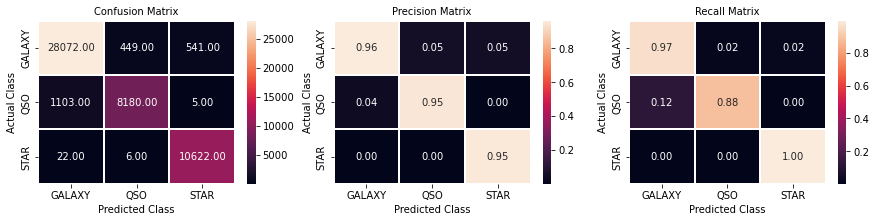

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     29062
         QSO       0.95      0.88      0.91      9288
        STAR       0.95      1.00      0.97     10650

    accuracy                           0.96     49000
   macro avg       0.95      0.95      0.95     49000
weighted avg       0.96      0.96      0.96     49000

---------------------------------------------------------------------------------
TEST
Accuracy:  0.9544285714285714
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


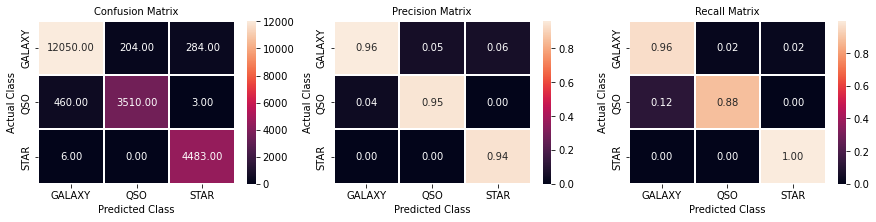

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.95      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000

---------------------------------------------------------------------------------
Cross-validation scores:  [0.95632653 0.95571429 0.95581633 0.9544898  0.95836735]
Mean CV score:  0.9561428571428572


In [167]:
# logistic regression
lg = LogisticRegression(max_iter=1000)
dist = dict(C=[10 ** x for x in range(-4, 3)], penalty=['l2', 'l1'])
lg_scores = train_and_evaluate_model(lg, param_grid=dist, X_train=X, y_train=y, X_test=X_test, y_test=y_test)

### 3.2. Random forest (criterion: Gini)

In [116]:
# random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, criterion='gini', bootstrap=True)
rf_score = score(rf, "Random Forest")

Random Forest confusion matrix:
[[12132   289   117]
 [  358  3614     1]
 [    1     0  4488]]


Random Forest accuracy for TEST data: 0.9635
Random Forest accuracy for TRAIN data: 0.9638
---------------------------------------
Random Forest weighted accuracy: 0.9637 
 ---------------------------------------
Random Forest classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     12538
         QSO       0.93      0.91      0.92      3973
        STAR       0.97      1.00      0.99      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Random Forest classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     29062
         QSO       0.93      0.90      0.92      9288
        STAR       0.98      1.00      0.99     10650

    accuracy                           0.96     49000
   macro avg       0.96      0.

### 3.3. Naive Bayes

In [117]:
nb = GaussianNB(priors=[0.5, 0.3, 0.2], var_smoothing=1e-6)   # prawdopodobieństwo klas (z takim ustawieniem accuracy jest wieksze niz z defaultowym)
nb_score = score(nb, "Naive Bayes GaussianNB")

Naive Bayes GaussianNB confusion matrix:
[[11255  1174   109]
 [  269  3702     2]
 [   53    64  4372]]


Naive Bayes GaussianNB accuracy for TEST data: 0.9204
Naive Bayes GaussianNB accuracy for TRAIN data: 0.9218
---------------------------------------
Naive Bayes GaussianNB weighted accuracy: 0.9214 
 ---------------------------------------
Naive Bayes GaussianNB classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.90      0.93     12538
         QSO       0.75      0.93      0.83      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.92     21000
   macro avg       0.90      0.93      0.91     21000
weighted avg       0.93      0.92      0.92     21000

Naive Bayes GaussianNB classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.90      0.93     29062
         QSO       0.76      0.93      0.83      9288
        STAR       0.98      0.97      0.98     10650

    accuracy                           0

### 3.4. K Neighbours

In [118]:
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_score = score(knn, "KNN")

KNN confusion matrix:
[[12068   145   325]
 [  279  3672    22]
 [  143     4  4342]]


KNN accuracy for TEST data: 0.9563
KNN accuracy for TRAIN data: 0.9659
---------------------------------------
KNN weighted accuracy: 0.963 
 ---------------------------------------
KNN classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.96     12538
         QSO       0.96      0.92      0.94      3973
        STAR       0.93      0.97      0.95      4489

    accuracy                           0.96     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.96      0.96      0.96     21000

KNN classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     29062
         QSO       0.98      0.93      0.95      9288
        STAR       0.95      0.98      0.96     10650

    accuracy                           0.97     49000
   macro avg       0.96      0.96      0.96     49000
weighted avg       0.97     

### 3.5. Drzewa decyzyjne (entropy)

In [119]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10)
dt_score = score(dt, "Decision Tree")

Decision Tree confusion matrix:
[[12315   185    38]
 [  316  3656     1]
 [   40     0  4449]]


Decision Tree accuracy for TEST data: 0.9724
Decision Tree accuracy for TRAIN data: 0.9826
---------------------------------------
Decision Tree weighted accuracy: 0.9795 
 ---------------------------------------
Decision Tree classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     12538
         QSO       0.95      0.92      0.94      3973
        STAR       0.99      0.99      0.99      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.97     21000
weighted avg       0.97      0.97      0.97     21000

Decision Tree classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     29062
         QSO       0.98      0.94      0.96      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           0.98     49000
   macro avg       0.98      0.

### 3.6. Drzewa decyzyjne (Gini)

In [121]:
gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt_gini_score = score(gini, "Gini")

Gini confusion matrix:
[[12284   161    93]
 [  383  3589     1]
 [    1     0  4488]]


Gini accuracy for TEST data: 0.9696
Gini accuracy for TRAIN data: 0.9714
---------------------------------------
Gini weighted accuracy: 0.9709 
 ---------------------------------------
Gini classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.90      0.93      3973
        STAR       0.98      1.00      0.99      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Gini classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     29062
         QSO       0.96      0.91      0.93      9288
        STAR       0.98      1.00      0.99     10650

    accuracy                           0.97     49000
   macro avg       0.97      0.96      0.97     49000
weighted avg       0.9

### 3.7. Ada boost classifier

In [127]:
ab = AdaBoostClassifier(n_estimators=100,random_state=101)
ab_score = score(ab,'Ada Boost')

Ada Boost confusion matrix:
[[  575 11846   117]
 [    1  3971     1]
 [    0     0  4489]]


Ada Boost accuracy for TEST data: 0.4302
Ada Boost accuracy for TRAIN data: 0.4309
---------------------------------------
Ada Boost weighted accuracy: 0.4307 
 ---------------------------------------
Ada Boost classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       1.00      0.05      0.09     12538
         QSO       0.25      1.00      0.40      3973
        STAR       0.97      1.00      0.99      4489

    accuracy                           0.43     21000
   macro avg       0.74      0.68      0.49     21000
weighted avg       0.85      0.43      0.34     21000

Ada Boost classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.99      0.04      0.08     29062
         QSO       0.25      1.00      0.40      9288
        STAR       0.98      1.00      0.99     10650

    accuracy                           0.43     49000
   macro avg       0.74      0.68      0.49     490

### 3.8. SVC

In [128]:
svc=SVC(kernel='rbf',random_state=101)
svc_score = score(svc,'SVC')

SVC confusion matrix:
[[12102   117   319]
 [  371  3597     5]
 [   46     0  4443]]


SVC accuracy for TEST data: 0.9591
SVC accuracy for TRAIN data: 0.9598
---------------------------------------
SVC weighted accuracy: 0.9596 
 ---------------------------------------
SVC classification report fot TEST data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     12538
         QSO       0.97      0.91      0.94      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.95     21000
weighted avg       0.96      0.96      0.96     21000

SVC classification report fot TRAIN data:
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     29062
         QSO       0.97      0.90      0.93      9288
        STAR       0.94      0.99      0.96     10650

    accuracy                           0.96     49000
   macro avg       0.96      0.95      0.95     49000
weighted avg       0.96    

## 4. Wybrany model
Podsumujmy badane accuracy scores. Uwzględniamy uśrednione accuracy score.

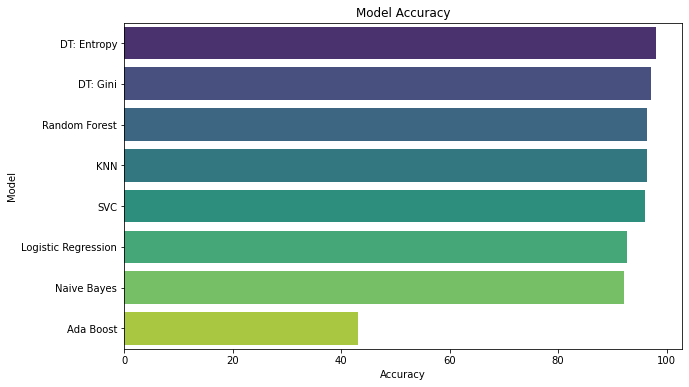

   Score                Model
4  97.95          DT: Entropy
5  97.09             DT: Gini
1  96.37        Random Forest
3  96.30                  KNN
7  95.96                  SVC
0  92.78  Logistic Regression
2  92.14          Naive Bayes
6  43.07            Ada Boost


In [131]:
x = {'Score' : [lg_score, rf_score, nb_score, knn_score, dt_score, dt_gini_score, ab_score, svc_score]}
df = pd.DataFrame(x)
df['Score'] = df['Score'] * 100
df['Model'] = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'DT: Entropy', 'DT: Gini', 'Ada Boost', 'SVC']
df = df.sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', data=df, palette='viridis')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# print model and score 
print(df)

Najlepszym modelem okazał się być *Decision Tree: Entropy*, niewiele gorszym - *Decision Tree: Gini*. Najgorzej wypada *Ada Boost*.